In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import scipy.stats as stats

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization

In [2]:
df = pd.read_excel('../../../data/tb_stock.xlsx')
df = df.iloc[-3000:, :][['sc_date', 'sc_ss_stock']]

# 날짜 데이터를 유지
df['sc_date'] = pd.to_datetime(df['sc_date'])

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['sc_ss_stock'].values.reshape(-1, 1))
df['samsung_Close_Scaled'] = scaled_data

In [3]:
# 데이터셋을 훈련과 테스트로 분리
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

# 시퀀스 데이터 생성 함수
def create_sequences_with_dates(data, dates, seq_length):
    X, y, y_dates = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
        y_dates.append(dates[i + seq_length])
    return np.array(X), np.array(y), np.array(y_dates)

# 50일치 데이터를 사용하여 다음 날을 예측
seq_length = 50

In [4]:
data = df['samsung_Close_Scaled'].values
dates = df['sc_date'].values
X, y, y_dates = create_sequences_with_dates(data, dates, seq_length)

X_train, X_test, y_train, y_test, y_train_dates, y_test_dates = train_test_split(X, y, y_dates, test_size=0.2, random_state=42, shuffle=False)

print(f'X_train shqpe : {X_train.shape}, y_train shape : {y_train.shape}')
print(f'X_test shqpe : {X_train.shape}, y_test shape : {y_train.shape}')

X_train shqpe : (2360, 50), y_train shape : (2360,)
X_test shqpe : (2360, 50), y_test shape : (2360,)


In [5]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y_test_dates length: {len(y_test_dates)}")


X shape: (2950, 50)
y shape: (2950,)
y_test_dates length: 590


In [6]:
# GRU 모델 정의
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

c:\Anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0252 - val_loss: 5.0699e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0028 - val_loss: 4.5226e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0020 - val_loss: 5.0234e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0019 - val_loss: 8.1263e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0018 - val_loss: 7.7315e-04
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0020 - val_loss: 4.3223e-04
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0015 - val_loss: 6.7858e-04
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0015 - val_loss: 4.5264e-04
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 12/50
74/74 ━━━━━━━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


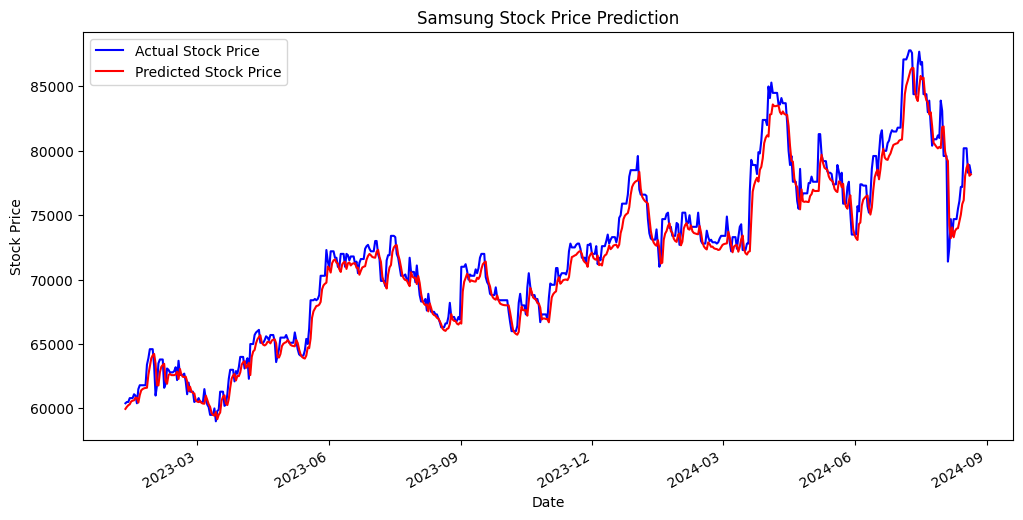

In [7]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test_scaled, color='blue', label='Actual Stock Price')
plt.plot(y_test_dates, predicted_stock_price, color='red', label='Predicted Stock Price')

# 한 달에 하나씩 날짜 표시 (간격을 월별로 설정)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('Samsung Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [8]:
# 모델 구축 함수
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', kernel_regularizer=l2(0.02)))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', kernel_regularizer=l2(0.02)))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))  # 최종 출력 레이어

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse')
    return model

In [9]:
# 짧은 경로 설정
logging_dir = os.path.abspath('C:/my_dir')

if os.path.exists(logging_dir):
    shutil.rmtree(logging_dir)

os.makedirs(logging_dir)

In [10]:
# Hyperparameter Tuner 설정
tuner = RandomSearch(
    build_model,
    objective           ='val_loss',
    max_trials          =10,              # 몇번 시도할건지 설정
    executions_per_trial=2,               # 각 조합을 더 많이 시도해 평균화
    directory           =logging_dir,
    project_name        ='gru_tuning'
)

In [11]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 교차검증 실행 및 최적 모델 탐색
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_fold = None
best_model = None
best_loss = float('inf')
best_hyperparameters = None

fold_no = 1

In [12]:
for train_index, test_index in kf.split(X):
    print(f'Training on fold {fold_no}...')
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 모델 학습
    tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    # 현재 폴드의 최적의 모델과 하이퍼파라미터 선택
    fold_best_model = tuner.get_best_models(num_models=1)[0]
    fold_best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # 현재 폴드의 모델 평가
    fold_loss = fold_best_model.evaluate(X_test, y_test)
    print(f'Fold {fold_no} - Loss: {fold_loss}')
    
    # 현재 폴드가 가장 좋은 성능을 보였다면, 해당 모델과 하이퍼파라미터 저장
    if fold_loss < best_loss:
        best_loss = fold_loss
        best_fold = fold_no
        best_model = fold_best_model
        best_hyperparameters = fold_best_hyperparameters
    
    fold_no += 1


Trial 10 Complete [00h 00m 54s]
val_loss: 0.08175185322761536

Best val_loss So Far: 0.005327247548848391
Total elapsed time: 00h 06m 30s
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047  


c:\Anaconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 - Loss: 0.005157695151865482
Training on fold 2...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050  
Fold 2 - Loss: 0.005540881305932999
Training on fold 3...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050  
Fold 3 - Loss: 0.005420472472906113
Training on fold 4...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051  
Fold 4 - Loss: 0.00558165367692709
Training on fold 5...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050  
Fold 5 - Loss: 0.005433314945548773


In [13]:
# 최적의 모델로 예측 수행
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 288)            │        14,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 288)            │        83,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,209 (383.63 KB)

 Trainable params: 98,209 (383.63 KB)

 Non-trainable params: 0 (0.00 B)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


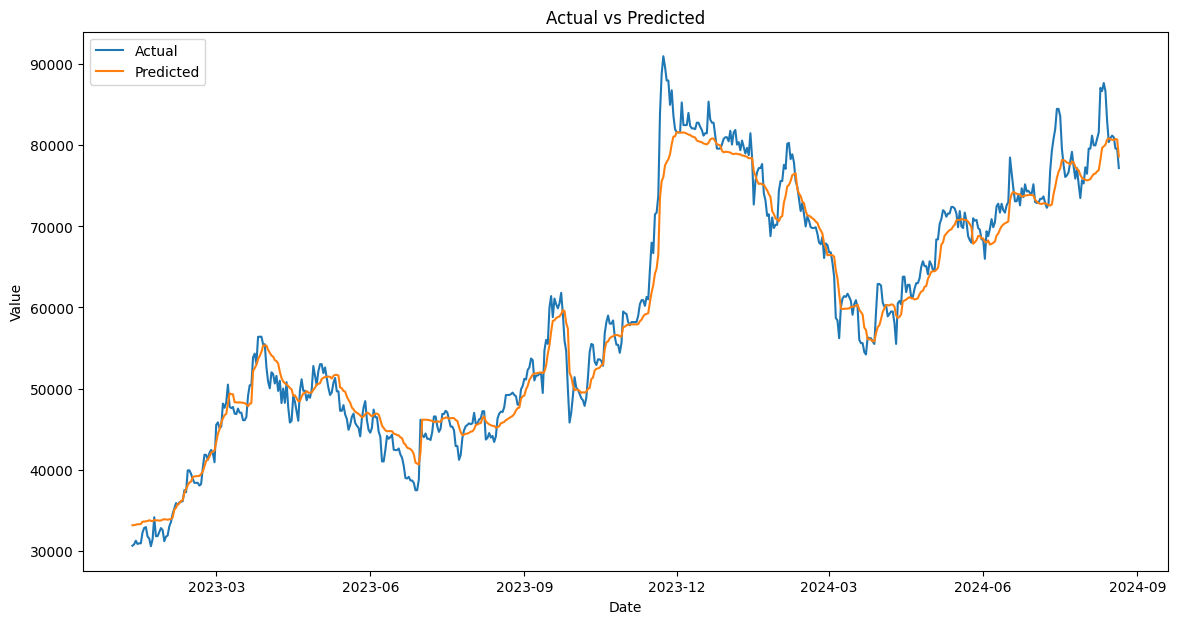

In [14]:
# 최적의 모델로 예측 수행
y_pred = best_model.predict(X_test)

# 예측 결과를 스케일링 원복
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 예측 결과와 실제 값을 비교하는 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(y_test_dates, y_test_scaled, label='Actual')
plt.plot(y_test_dates, y_pred, label='Predicted')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [15]:
# 학습 데이터에 대한 예측
y_train_pred = best_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_train_scaled = scaler.inverse_transform(y_train.reshape(-1, 1))

# MSE 계산
train_mse = mean_squared_error(y_train_scaled, y_train_pred)
test_mse = mean_squared_error(y_test_scaled, y_pred)

# R-squared 계산
train_r2 = r2_score(y_train_scaled, y_train_pred)
test_r2 = r2_score(y_test_scaled, y_pred)

# 결과 출력
print(f'Train MSE: {train_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Train R-squared: {train_r2:.4f}')
print(f'Test R-squared: {test_r2:.4f}')

# 과대적합/과소적합 여부 확인
if train_mse < test_mse and (train_mse / test_mse) < 0.8:
    print("과대적합이 발생할 가능성이 있습니다.")
elif train_mse > test_mse and (test_mse / train_mse) < 0.8:
    print("과소적합이 발생할 가능성이 있습니다.")
else:
    print("모델이 적절하게 학습된 것으로 보입니다.")

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train MSE: 7042515.3250
Test MSE: 7075416.5272
Train R-squared: 0.9660
Test R-squared: 0.9685
모델이 적절하게 학습된 것으로 보입니다.


In [16]:
def predict_future_prices(gru_model, recent_60_days_data, scaler, future_days=30):
    """
    60일간의 데이터를 기반으로 1개월 동안의 주가를 예측하는 함수.
    
    Parameters:
    - gru_model: 이미 학습된 모델 (GRU가 아닐 경우 Dense 레이어 기반)
    - recent_60_days_data: 최근 60일간의 스케일링된 주가 데이터 (numpy array)
    - scaler: MinMaxScaler 객체
    - future_days: 예측할 미래 일수 (기본값: 30일)
    
    Returns:
    - predictions_scaled_back: 예측된 주가를 원래 스케일로 복원한 값 (numpy array)
    - future_dates: 예측된 주가에 해당하는 미래 날짜 (pandas DatetimeIndex)
    """
    
    predictions = []
    latest_sequence = recent_60_days_data[-50:]  # 최근 50일간의 데이터를 사용 (모델에 맞게 조정)

    # 시퀀스 데이터를 사용하여 미래 예측 반복
    for _ in range(future_days):
        # 현재 시퀀스를 모델에 입력하여 예측 수행 (reshape to match the model's expected input)
        latest_sequence_reshaped = latest_sequence.reshape(1, -1)  # (1, 50)으로 reshape
        prediction = gru_model.predict(latest_sequence_reshaped)
        
        # 예측 결과를 저장하고, 시퀀스를 업데이트하여 다음 예측 준비
        predictions.append(prediction[0, 0])
        latest_sequence = np.append(latest_sequence[1:], prediction)
    
    # 예측된 값을 원래 스케일로 변환
    predictions_scaled_back = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    # 예측 날짜 생성 (최근 60일 데이터의 마지막 날짜로부터 미래 30일 생성)
    last_date = pd.to_datetime(df['sc_date'].values[-1])
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_days)
    
    return predictions_scaled_back, future_dates


def plot_predictions(past_60_days, past_60_dates, predictions_scaled_back, future_dates):
    """
    과거 60일간의 데이터와 예측된 30일간의 데이터를 그래프로 시각화하는 함수.
    
    Parameters:
    - past_60_days: 과거 60일간의 주가 데이터 (numpy array)
    - past_60_dates: 과거 60일간의 날짜 데이터 (pandas DatetimeIndex)
    - predictions_scaled_back: 예측된 주가 데이터 (numpy array)
    - future_dates: 예측된 주가에 해당하는 미래 날짜 (pandas DatetimeIndex)
    """
    
    plt.figure(figsize=(10, 6))
    plt.plot(past_60_dates, past_60_days, label='Historical Stock Price (Last 60 Days)', color='blue')
    plt.plot(future_dates, predictions_scaled_back, label='Predicted Future Stock Price (Next 30 Days)', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Prediction for the Next 30 Days')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

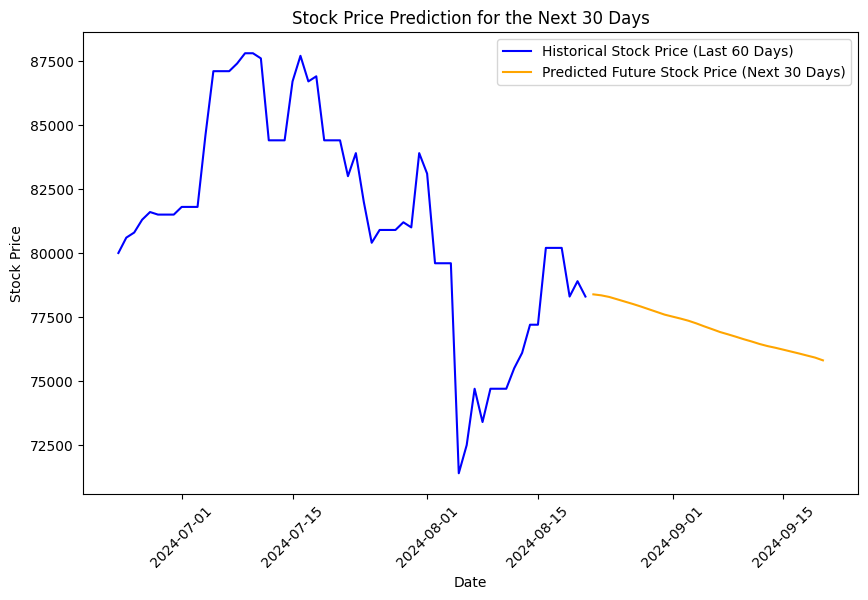

In [17]:
# 함수 사용 예시
recent_60_days_data = df['samsung_Close_Scaled'].values[-60:]  # 최근 60일간의 데이터 추출
past_60_days = df['sc_ss_stock'].values[-60:]                  # 원래 스케일의 최근 60일 데이터
past_60_dates = df['sc_date'].values[-60:]                     # 최근 60일간의 날짜 데이터

# 미래 30일 동안의 주가 예측
predictions_scaled_back, future_dates = predict_future_prices(best_model, recent_60_days_data, scaler)

# 예측 결과 시각화
plot_predictions(past_60_days, past_60_dates, predictions_scaled_back, future_dates)

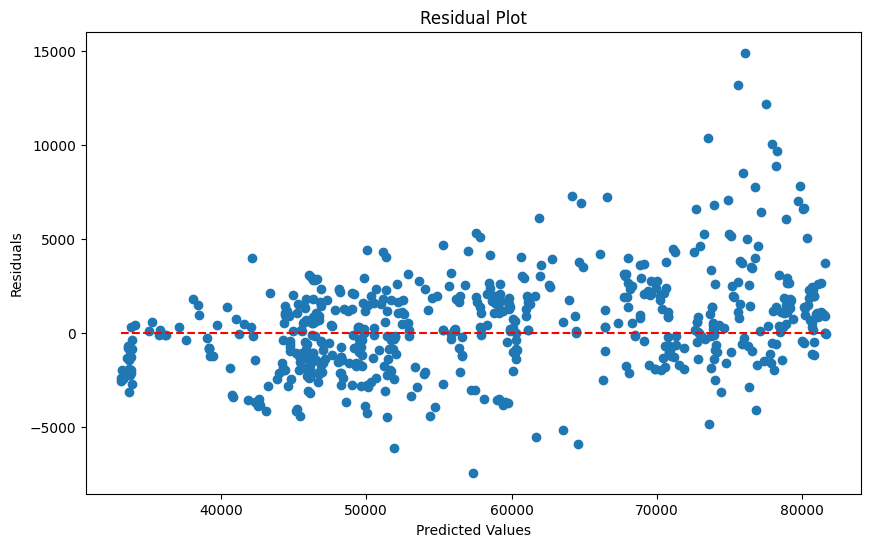

In [18]:
# 잔차 계산
residuals = y_test_scaled - y_pred

# 1. 잔차 플롯
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

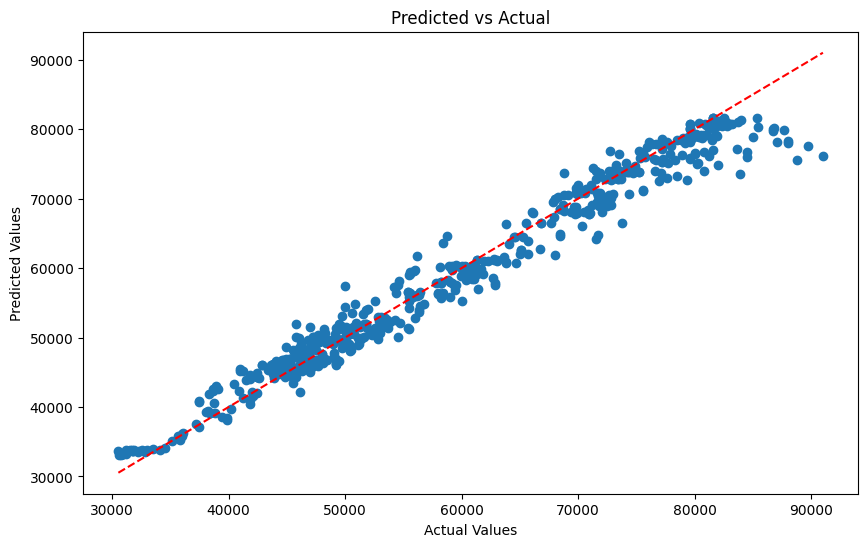

In [19]:
# 2. 예측 vs 실제 값 플롯
plt.figure(figsize=(10, 6))
plt.scatter(y_test_scaled, y_pred)
plt.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'r--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

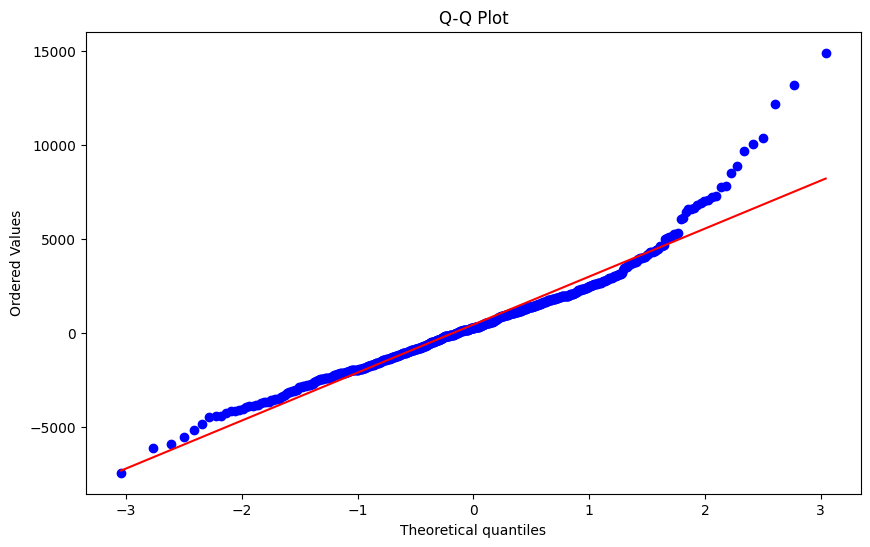

In [20]:
# 4. Q-Q 플롯
plt.figure(figsize=(10, 6))
stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

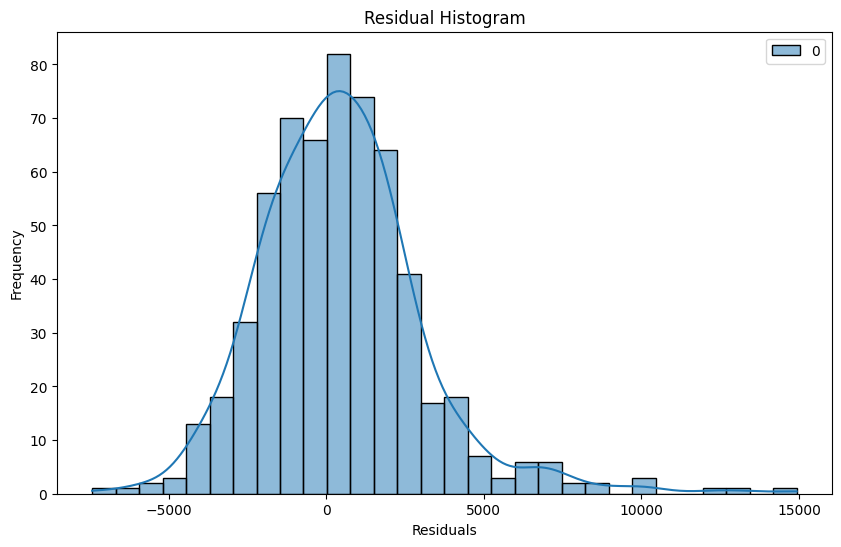

In [21]:
# 3. 잔차 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [22]:
# 최적의 하이퍼파라미터를 사용해 모델을 다시 학습
print(f'\nBest model found at fold {best_fold} with loss {best_loss}')
print(f'Best hyperparameters: {best_hyperparameters.values}')

# 최적의 모델을 다시 저장
final_model_save_path = "../saved_models/regression_samsung_gru.h5"
best_model.save(final_model_save_path)
print(f'Final best model saved at {final_model_save_path}')


Best model found at fold 1 with loss 0.005157695151865482
Best hyperparameters: {'units': 288, 'dropout_rate': 0.2, 'learning_rate': 8.670648662848804e-05}
Final best model saved at ../saved_models/regression_samsung_gru.h5
